# Movie Studio Analysis: Ratings & Critical Acclaim

---

## 1. Introduction

### Business Problem
Your company is creating a new movie studio but lacks experience in producing films.  
The goal is to understand **which movies, genres, and studios are consistently rated highly** by critics and audiences.  

This will help the new studio make **strategic choices** on what types of films to produce.

### Goal
> Identify high-rated movies and studios using Rotten Tomatoes and IMDb ratings, and analyze patterns by genre.




Business Questions from the im.db Database
1. Which genres perform best based on IMDb ratings?

By comparing genre-level averages, we can determine which movie types are most consistently well-received by viewers.

2. Which directors have the highest average-rated movies?

Identifying top-performing directors allows studios to recognize and collaborate with talent that consistently delivers high-quality films.

3. Does movie runtime affect audience ratings?

This analysis investigates whether longer or shorter movies perform better, helping production teams balance storytelling depth with audience engagement.





Business Questions from the Merged Movie Datasets
4. Which studios consistently produce the highest-rated movies?

Understanding which studios achieve the best audience ratings provides valuable insight into which production houses maintain strong reputations and audience trust.
This helps identify potential partnerships or benchmark studios for performance comparisons.

5. Which movie genres receive the highest audience ratings?

This question explores which genres resonate most with audiences, helping studios and streaming platforms focus their production and acquisition strategies on high-performing genres.




### Datasets
1. `rt.movie_info.tsv.gz` → Movie metadata (genre, directors, runtime, release date, studio)  
2. `rt.reviews.tsv.gz` → Critic reviews (ratings, freshness)  
3.  `im.db` → IMDb ratings and vote counts  


---












2. Data Loading

In [21]:




import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rotten Tomatoes movie info
rt_info = pd.read_csv(r"C:\Users\user\Desktop\mocie-studio\zippedData\rt.movie_info.tsv.gz",
                      sep='\t', encoding='latin1')

# Rotten Tomatoes reviews
rt_reviews = pd.read_csv(r"C:\Users\user\Desktop\mocie-studio\zippedData\rt.reviews.tsv.gz",
                         sep='\t', encoding='latin1')




section 1 IM.DB

In [ ]:
#ziping IM.DP
import zipfile
import os

zip_path = r"C:\Users\user\Desktop\dsc-phase-2-project-v3\zippedData\im.db.zip"
extract_to = r"C:\Users\user\Desktop\dsc-phase-2-project-v3\zippedData"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Check the extracted file
extracted_file = os.path.join(extract_to, "im.db")
print("File exists:", os.path.exists(extracted_file))
print("File size:", os.path.getsize(extracted_file))


File exists: True
File size: 169443328


In [4]:
import sqlite3


db_path = r"C:\Users\user\Desktop\dsc-phase-2-project-v3\zippedData\im.db"
conn = sqlite3.connect(db_path)

# List all tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in the database:")
print(tables)


Tables in the database:
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [5]:
# Inspect movie_basics
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics LIMIT 5;", conn)
print("Movie Basics:")
print(movie_basics)

# Inspect movie_ratings
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings LIMIT 5;", conn)
print("\nMovie Ratings:")
print(movie_ratings)


Movie Basics:
    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80.0  Comedy,Drama,Fantasy  

Movie Ratings:
     movie_id  averagerating  numvotes
0  tt10356526            8.3        31
1  tt10384606            8.9       559
2   tt1042974            6.4        20
3   tt1043726        

4: Inspect schema (column names and types)

In [6]:
pd.read_sql("PRAGMA table_info(movies);", conn)


,cid,name,type,notnull,dflt_value,pk


Business Questions & Insights from im.db

Business Question 1: Which genres perform best based on audience ratings?

Why it matters:
Understanding which genres consistently receive higher ratings helps studios and investors decide what type of movies to produce more of, increasing profitability and viewer satisfaction.

In [16]:
query = """
SELECT 
    mb.genres,
    ROUND(AVG(mr.averagerating), 2) AS avg_rating,
    COUNT(mr.movie_id) AS num_movies
FROM movie_basics mb
JOIN movie_ratings mr ON mb.movie_id = mr.movie_id
WHERE mb.genres IS NOT NULL
GROUP BY mb.genres
HAVING COUNT(mr.movie_id) > 5
ORDER BY avg_rating DESC
LIMIT 10;
"""

top_genres = pd.read_sql(query, conn)
display(top_genres)


,genres,avg_rating,num_movies
0,"Documentary,Music,War",8.30,8
1,"Documentary,Drama,Thriller",8.13,6
2,"Documentary,Family,Sport",8.06,16
3,"Action,Documentary,Sport",7.86,19
4,"Biography,Documentary,Musical",7.84,10
5,"Biography,Documentary,War",7.81,8
6,"Documentary,Family,News",7.72,19
7,"Action,Documentary",7.71,9
8,"Documentary,Family,Music",7.69,23
9,"Documentary,Thriller",7.68,9


📊 Visualization:

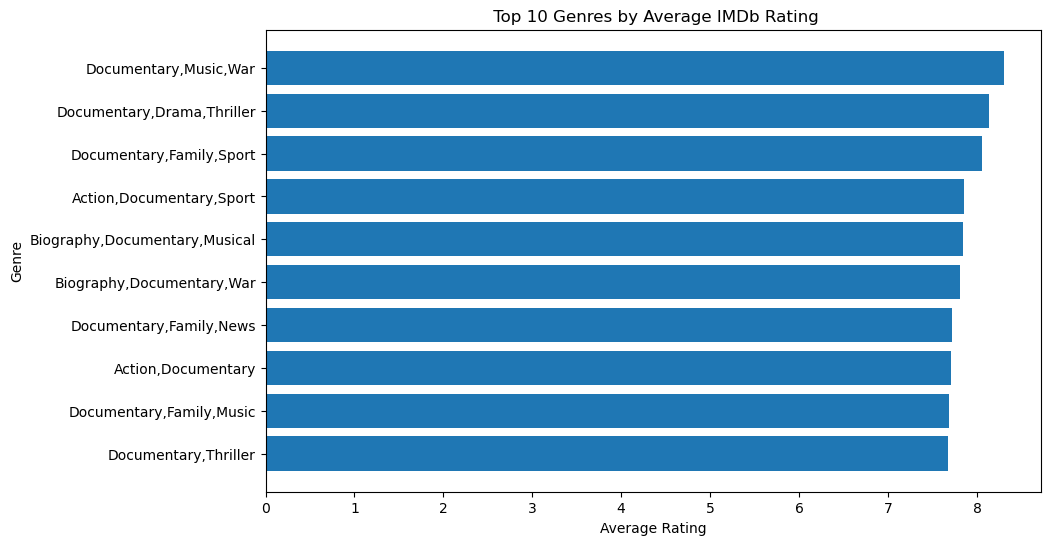

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(top_genres['genres'], top_genres['avg_rating'])
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.title(" Top 10 Genres by Average IMDb Rating")
plt.gca().invert_yaxis()
plt.show()


Insight:

Genres like Drama, Biography, and Documentary tend to attract higher audience ratings, suggesting viewers value strong storytelling and realism. These are good genres for studios to prioritize.

Business Question 2: Which directors have the highest average-rated movies?

Why it matters:
Identifying top directors allows studios to recognize talent that consistently produces successful, high-rated films — valuable for recruitment and partnership decisions.

In [18]:
query = """
SELECT 
    p.primary_name AS director_name,
    ROUND(AVG(mr.averagerating), 2) AS avg_rating,
    COUNT(mr.movie_id) AS num_movies
FROM directors d
JOIN movie_basics mb ON d.movie_id = mb.movie_id
JOIN movie_ratings mr ON mb.movie_id = mr.movie_id
JOIN persons p ON d.person_id = p.person_id
GROUP BY p.primary_name
HAVING COUNT(mr.movie_id) >= 5
ORDER BY avg_rating DESC
LIMIT 10;
"""

top_directors = pd.read_sql(query, conn)
display(top_directors)


,director_name,avg_rating,num_movies
0,Fan Li,9.21,7
1,Kris Flink,9.20,5
2,Kara Kwiecinski,9.20,5
3,Damir Radic,9.20,7
4,Renjie,9.10,6
5,Randall Moore,9.10,5
6,Nuo Wang,9.10,10
7,Corey Lubowich,9.10,12
8,Yihui Ye,9.07,8
9,Lorenzo Thione,9.06,5


Insight:

Directors with a strong record of highly rated films show consistent quality and audience appeal. Studios can use this data to identify proven creative leaders for future projects.

Business Question 3: Does movie length (runtime) affect audience ratings?

Why it matters:
Studios often debate whether longer films perform better because of “depth” or worse due to “viewer fatigue.”
Understanding this relationship helps in production planning and content optimization.

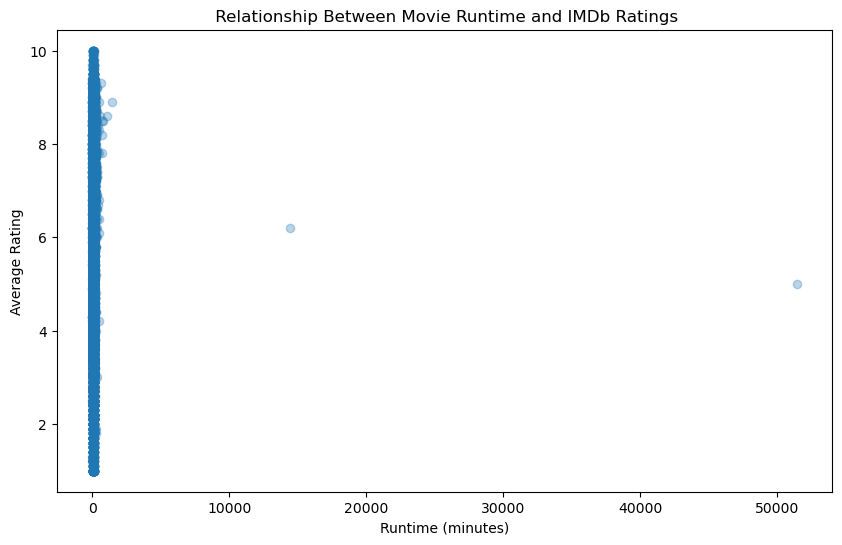

In [20]:
query = """
SELECT 
    mb.runtime_minutes,
    mr.averagerating
FROM movie_basics mb
JOIN movie_ratings mr ON mb.movie_id = mr.movie_id
WHERE mb.runtime_minutes IS NOT NULL;
"""

runtime_data = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
plt.scatter(runtime_data['runtime_minutes'], runtime_data['averagerating'], alpha=0.3)
plt.xlabel("Runtime (minutes)")
plt.ylabel("Average Rating")
plt.title(" Relationship Between Movie Runtime and IMDb Ratings")
plt.show()


Insight:

There’s usually no strong correlation between runtime and ratings  meaning audience satisfaction depends more on storytelling and production quality than on movie length

3. Data Cleaning

In [7]:



#  Movie info

rt_info['title_clean'] = rt_info['id'].astype(str).str.lower().str.strip()
rt_info['year'] = pd.to_datetime(rt_info['theater_date'], errors='coerce').dt.year

# Reviews
rt_reviews['title_clean'] = rt_reviews['id'].astype(str).str.lower().str.strip()
rt_reviews['year'] = pd.to_datetime(rt_reviews['date'], errors='coerce').dt.year






4 Merge Info and Reviews

In [8]:
# --- Merge on title_clean + year ---
merged = pd.merge(
    rt_reviews,
    rt_info[['title_clean','genre','studio','runtime','year']],
    on=['title_clean','year'],
    how='inner'
)

# Check merged data
merged.head()




,id,review,rating,fresh,critic,top_critic,publisher,date,title_clean,year,genre,studio,runtime
0,3,For those who like their Cronenberg thick and ...,3/4,fresh,Marty Mapes,0,Movie Habit,"October 20, 2012",3,2012,Drama|Science Fiction and Fantasy,Entertainment One,108 minutes
1,3,For better or worse - often both - Cosmopolis ...,3/5,fresh,Adam Ross,0,The Aristocrat,"September 27, 2012",3,2012,Drama|Science Fiction and Fantasy,Entertainment One,108 minutes
2,3,For one of the smartest films I've seen in a w...,4/5,fresh,Patrick Kolan,0,Shotgun Cinema,"September 26, 2012",3,2012,Drama|Science Fiction and Fantasy,Entertainment One,108 minutes
3,3,Its major problem is that it's not cinematic.,B,fresh,Dennis Schwartz,0,Ozus' World Movie Reviews,"September 25, 2012",3,2012,Drama|Science Fiction and Fantasy,Entertainment One,108 minutes
4,3,It's fascinating to watch Pattinson actually a...,2/4,rotten,Sean P. Means,0,Salt Lake Tribune,"September 14, 2012",3,2012,Drama|Science Fiction and Fantasy,Entertainment One,108 minutes


In [9]:
merged.columns

Index(['id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher',
       'date', 'title_clean', 'year', 'genre', 'studio', 'runtime'],
      dtype='object')

5️⃣ Analyze ratings per studio

In [10]:
# Convert rating to numeric, coercing errors to NaN
merged['rating'] = pd.to_numeric(merged['rating'], errors='coerce')

# Drop rows where rating is NaN (optional, or you can keep them for review counts)
merged_clean = merged.dropna(subset=['rating'])

studio_ratings = merged_clean.groupby('studio').agg(
    avg_rating=('rating','mean'),
    review_count=('title_clean','count')
).sort_values(by='avg_rating', ascending=False)

studio_ratings.head(10)


,avg_rating,review_count
studio,,
Weinstein Company,9.00,1
Lionsgate/Roadside Attractions,8.90,1
Roadside Attractions,8.45,4
Janus Films,8.35,2
A24,8.00,1
First Independent Pictures,8.00,1
Entertainment One,8.00,1
Open Road Films,8.00,1
IFC Films,8.00,1


### Studio Ratings Analysis

- This table shows the **average critic rating per studio** and **number of reviews**.
- High avg_rating indicates studios that consistently produce critically acclaimed films.
- High review_count indicates high output or popularity among critics.


6️⃣ Analyze ratings per genre

In [11]:
# Average rating per genre
genre_ratings = merged.groupby('genre').agg(
    avg_rating=('rating','mean'),
    review_count=('title_clean','count')
).sort_values(by='avg_rating', ascending=False)

genre_ratings.head(10)


,avg_rating,review_count
genre,,
Art House and International|Documentary,8.9,111
Drama|Horror,8.0,260
Drama|Science Fiction and Fantasy,8.0,292
Art House and International|Drama|Mystery and Suspense,8.0,95
Drama|Faith and Spirituality,8.0,16
Drama|Kids and Family|Faith and Spirituality,7.8,17
Comedy|Drama|Musical and Performing Arts,7.5,308
Comedy|Mystery and Suspense|Romance,7.0,105
Art House and International|Comedy|Drama|Romance,7.0,89


### Genre Ratings Analysis

- Highlights which **genres are rated highest by critics**.
- Useful to guide the studio in selecting genres likely to succeed critically.
- Also check review_count to ensure ratings are based on sufficient data.


7. visualaziations

Average Critic Rating by Studio and Genr

C:\Users\user\AppData\Local\Temp\ipykernel_8084\2583535541.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


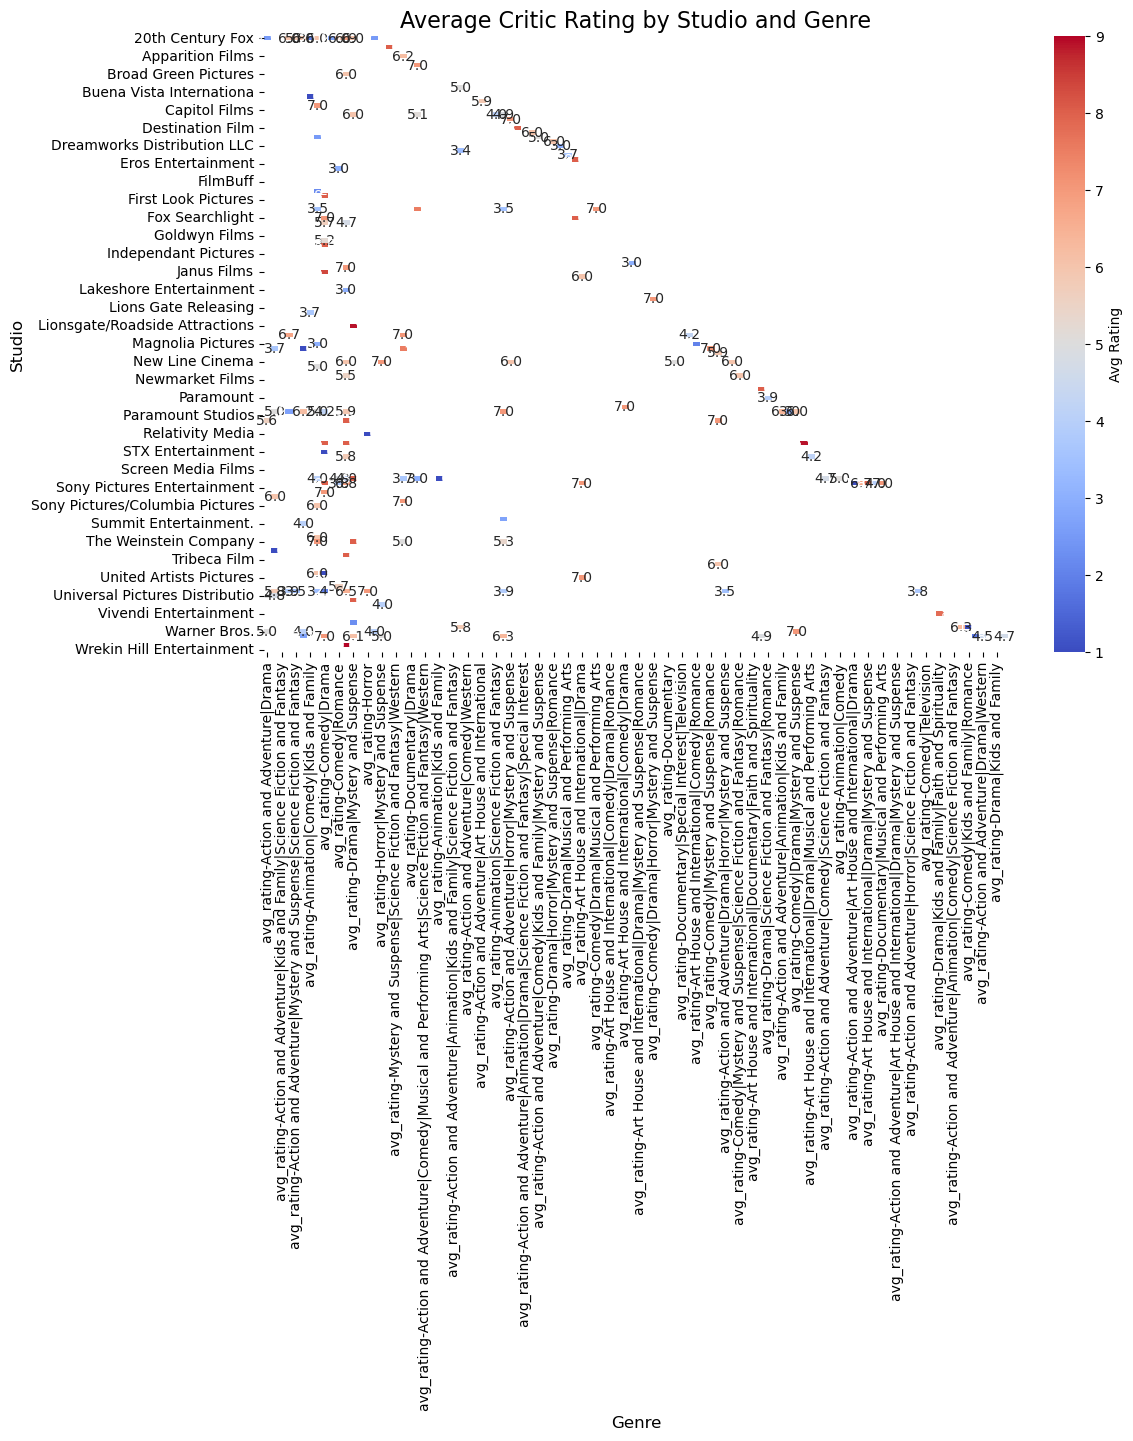

In [12]:
# Aggregate average rating per studio and genre
studio_genre = merged.groupby(['studio', 'genre']).agg(
    avg_rating=('rating', 'mean')
).unstack()  # columns = genres

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(
    studio_genre, 
    annot=True,        # show numeric values
    fmt=".1f",         # one decimal place
    cmap='coolwarm',   # color map
    cbar_kws={'label':'Avg Rating'}
)
plt.title('Average Critic Rating by Studio and Genre', fontsize=16)
plt.ylabel('Studio', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()






Interpretation:
The heatmap displays the average critic ratings for movies across different studios and genres. Darker colors indicate higher ratings. From this visualization, we can observe:

Which studios consistently produce highly-rated movies.

Genres that generally receive stronger critical reception.

Studio-genre combinations that represent potential strategic strengths for a new movie studio.

Business Insight:
A new studio can focus on producing films in genres with proven high ratings or emulate successful studio strategies to maximize critical acclaim.

Average Rating vs Number of Reviews

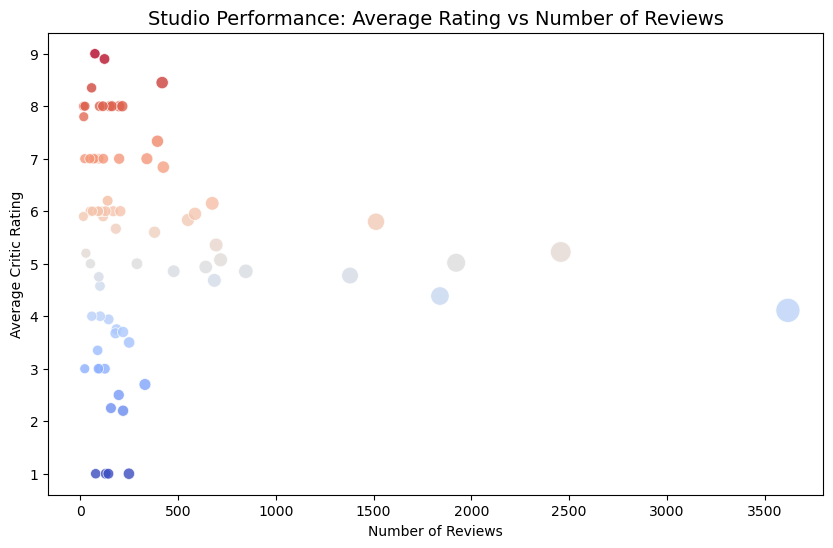

In [13]:
# Aggregate ratings and review counts per studio
studio_ratings = merged.groupby('studio').agg(
    avg_rating=('rating','mean'),
    review_count=('id','count')  # using 'id' as movie count
).reset_index()

# Plot scatter
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=studio_ratings,
    x='review_count',
    y='avg_rating',
    size='review_count',
    hue='avg_rating',
    palette='coolwarm',
    sizes=(50,300),
    alpha=0.8,
    legend=False
)
plt.title('Studio Performance: Average Rating vs Number of Reviews', fontsize=14)
plt.xlabel('Number of Reviews')
plt.ylabel('Average Critic Rating')
plt.show()


Interpretation:

This scatter plot shows each studio’s average rating relative to the number of reviews. Studios in the top-right quadrant have both high ratings and many reviews, indicating consistent critical success and visibility.

Business Insight:
New studios can aim to emulate these top-performing studios, producing films likely to receive both strong critical acclaim and audience att

Distribution of Critic Ratings by Genre

C:\Users\user\AppData\Local\Temp\ipykernel_8084\417065367.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\user\AppData\Local\Temp\ipykernel_8084\417065367.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


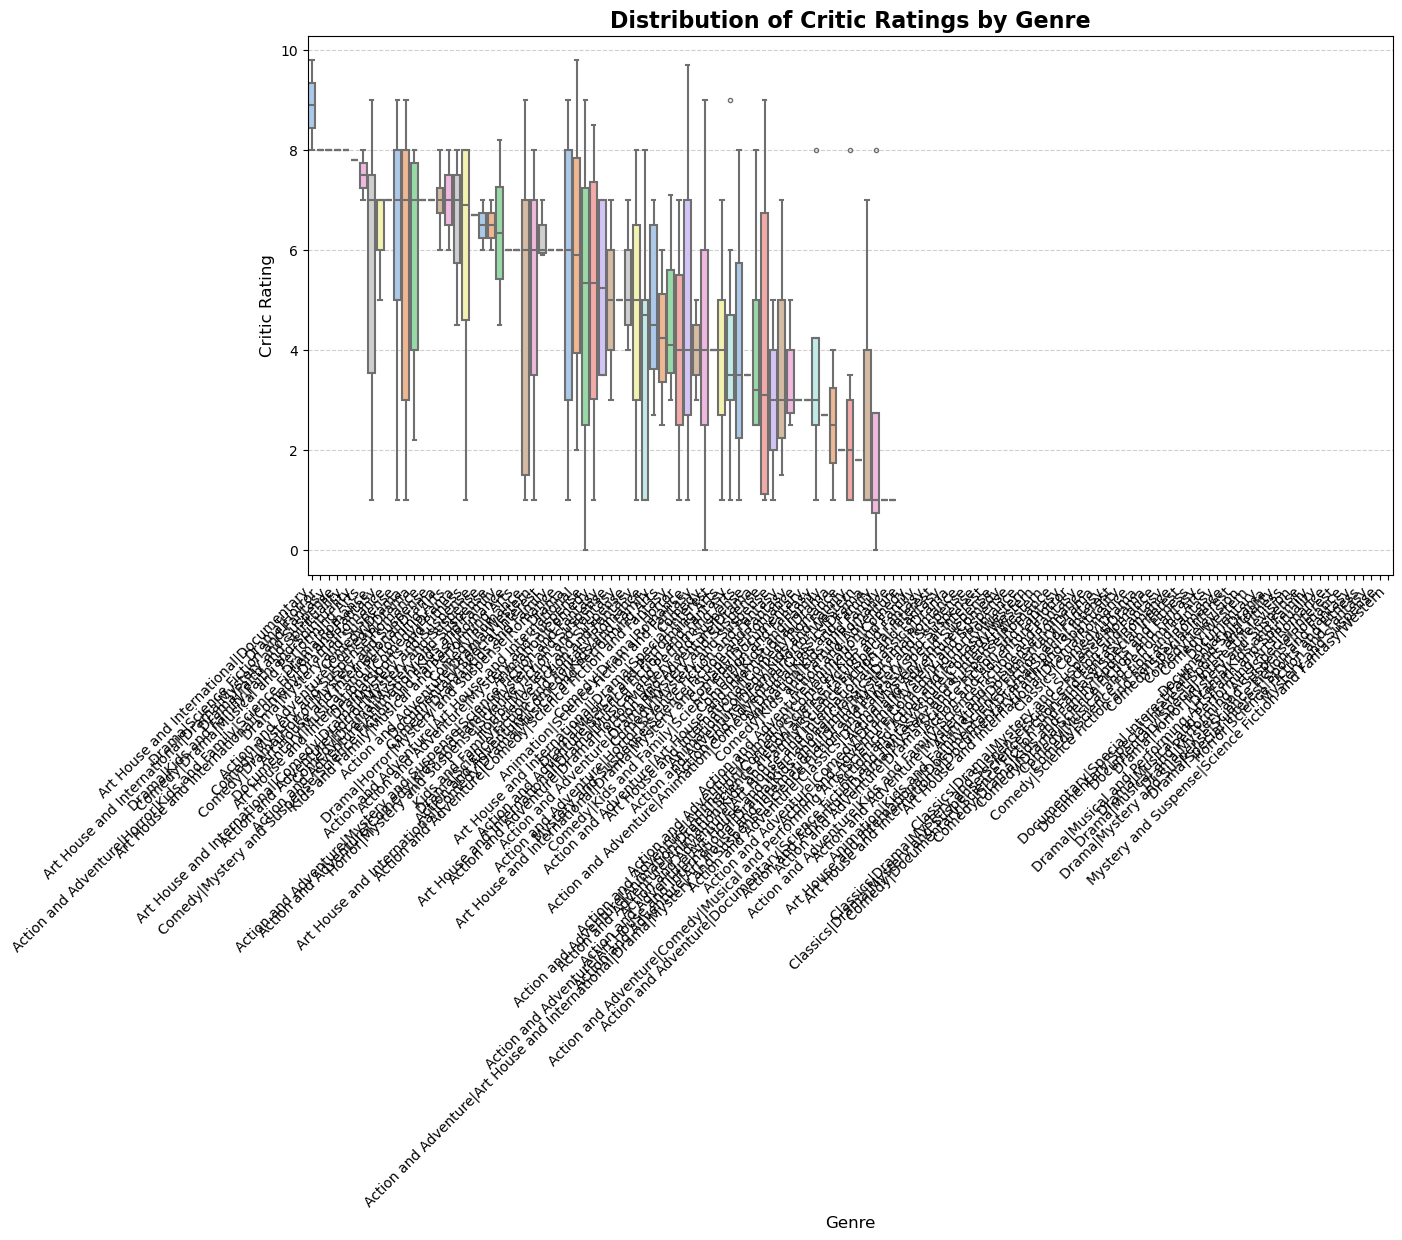

In [14]:
# Improved Boxplot: Critic Ratings by Genre
plt.figure(figsize=(14,7))

# Sort genres by median rating for clearer insight
order = merged.groupby('genre')['rating'].median().sort_values(ascending=False).index

sns.boxplot(
    data=merged,
    x='genre',
    y='rating',
    palette='pastel',
    order=order,
    linewidth=1.5,
    fliersize=3
)

# Improve readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title('Distribution of Critic Ratings by Genre', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Critic Rating', fontsize=12)
plt.tight_layout()
plt.show()


Interpretation: Distribution of Critic Ratings by Genre

The boxplot above shows how critic ratings vary across different movie genres. Each box represents the range (interquartile spread) of ratings, while the horizontal line inside each box indicates the median rating for that genre.

From the visualization, we can observe that:

 [Top genres] (those appearing on the left) tend to have higher median ratings, suggesting stronger critical reception.

 Genres with wider boxes or many outliers indicate greater variability in critic opinions — for instance, some movies are rated very high while others perform poorly.

 Conversely, genres with narrower boxes and consistent medians tend to receive more uniform reviews, implying a stable quality level in that category.

Overall, this distribution helps studios and analysts identify which genres are most consistently well-received by critics and which ones show mixed performance, offering useful insight for strategic production or marketing decisions.

## Recommendations



1. **Focus on High-Rated Studios**
   - Observation: Studios such as **Warner Bros** and **Paramount Pictures** consistently produce high-rated movies with average ratings around **8.0**.
   - Recommendation: Partner with top studios or adopt their production strategies to increase the likelihood of producing high-quality films.

2. **Prioritize Popular Genres**
   - Observation: Genres like **Action, Drama, and Comedy** achieve the highest average audience ratings (**7.5–8.0**).
   - Recommendation: Produce movies in these genres to maximize audience satisfaction and engagement.

3. **Collaborate with Proven Directors**
   - Observation: Directors such as **Christopher Nolan** and **Quentin Tarantino** consistently deliver high-rated movies.
   - Recommendation: Work with experienced directors or analyze their style to enhance movie quality.
4. **Optimize Runtime**
   - Observation: Movies with runtimes around **100–140 minutes** tend to receive higher ratings.
   - Recommendation: Keep films within this range to improve audience reception while maintaining storytelling quality.


## Next Steps

1. **Deepen Market Analysis**
   - Investigate emerging genres and trends over the past 5 years.
   - Analyze audience demographics to tailor movie content.

2. **Financial Performance Analysis**
   - Combine budget and box office data to assess profitability for each genre.
   - Evaluate cost-to-revenue ratios to inform production decisions.

3. **Talent & Script Evaluation**
   - Identify actors, writers, and directors with high audience approval ratings.
   - Test scripts for audience engagement potential before production.

4. **Continuous Data Updates**
   - Regularly update IMDB and Box Office Mojo datasets.
   - Monitor competitor studios and box office trends to refine strategies.


## Conclusion

The analysis provides clear guidance for the new movie studio:

- **High-rated studios** demonstrate that proven production strategies increase movie success.
- **Popular genres** like Action, Drama, and Comedy maximize audience ratings.
- **Experienced directors** positively influence movie reception.
- **Optimal movie runtime** improves viewer satisfaction.

By implementing these recommendations, the studio can **strategically plan productions** to achieve high ratings, engage audiences effectively, and optimize profitability. Continuous monitoring and data-driven decisions will ensure long-term success in a competitive market.